<a href="https://colab.research.google.com/github/ParhamPishro/Solutions-of-FUM-Academic-Exercises/blob/main/Deep%20Learning/8_Conditional_DCGAN_for_Tom_Bitmoji_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as utils

In [ ]:
! git clone https://github.com/fum-cs/neural-networks.git


Cloning into 'neural-networks'...
remote: Enumerating objects: 5326, done.
remote: Counting objects: 100% (956/956), done.
remote: Compressing objects: 100% (370/370), done.
remote: Total 5326 (delta 519), reused 924 (delta 487), pack-reused 4370 (from 1)
Receiving objects: 100% (5326/5326), 130.66 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (524/524), done.


##Display Images
###Tom

/content/neural-networks/notebooks/data/bitmoji_rgb/train/tom /content/neural-networks/notebooks/data/bitmoji_rgb/train/tom
1616


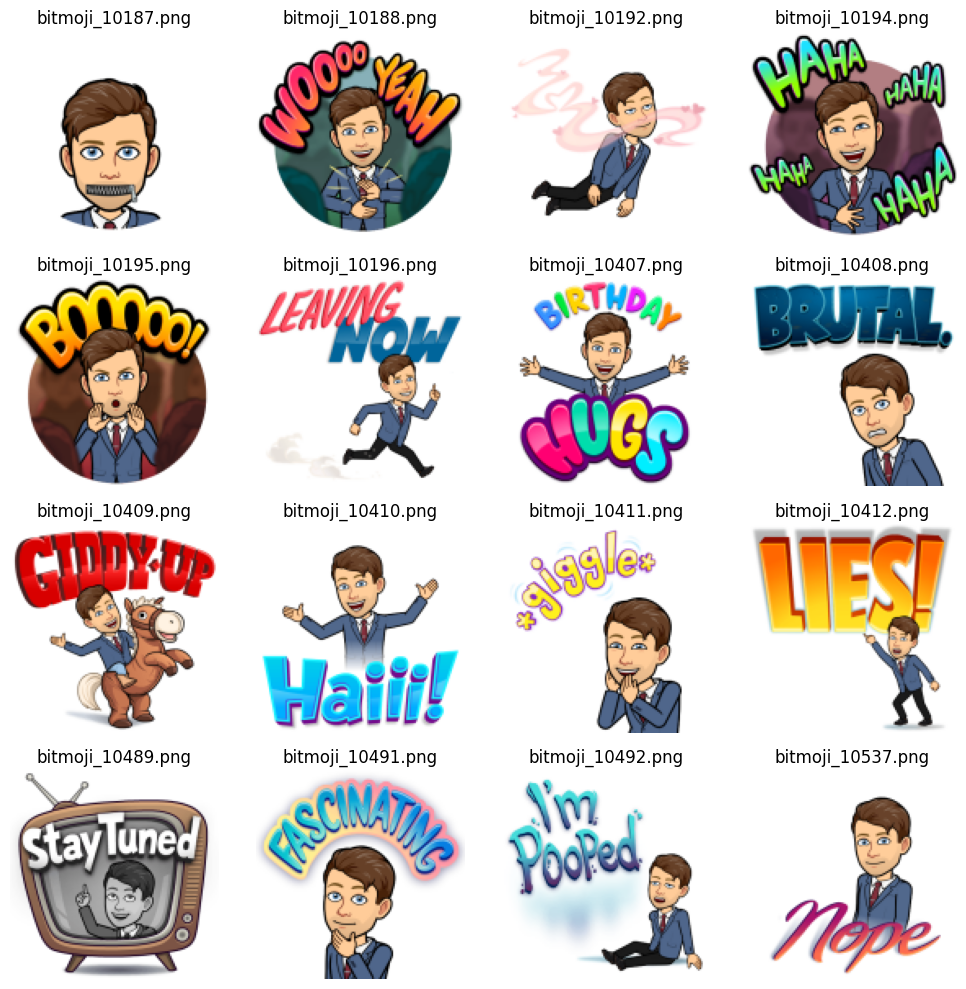

In [ ]:
 # Function to read and display images
def display_images(image_folder, num_images=5):  # Default number of images is 5
    # Check if the path exists
    if not os.path.exists(image_folder):
        print("The path does not exist.")
        return

    # List all image files in the folder
    images = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))])

    if not images:
        print("No images found in this path.")
        return

    # Select a certain number of images from the beginning
    selected_images = images[:num_images]  # Select the first num_images images

    # Display images
    plt.figure(figsize=(10, 10))
    for i, image_name in enumerate(selected_images):
        image_path = os.path.join(image_folder, image_name)
        image = Image.open(image_path)

        # For displaying in Grid
        plt.subplot(4, 4, i + 1)  # Display in a grid layout
        plt.imshow(image)
        plt.axis('off')  # Hide the axes
        plt.title(image_name)

    plt.tight_layout()
    plt.show()

# Input the folder path and the number of images to display
image_folder_path = input("/content/neural-networks/notebooks/data/bitmoji_rgb/train/tom ")
num_images_to_display = int(input("16"))
display_images(image_folder_path, num_images_to_display)

###Not Tom

/content/neural-networks/notebooks/data/bitmoji_rgb/train/not_tom/content/neural-networks/notebooks/data/bitmoji_rgb/train/not_tom
1616


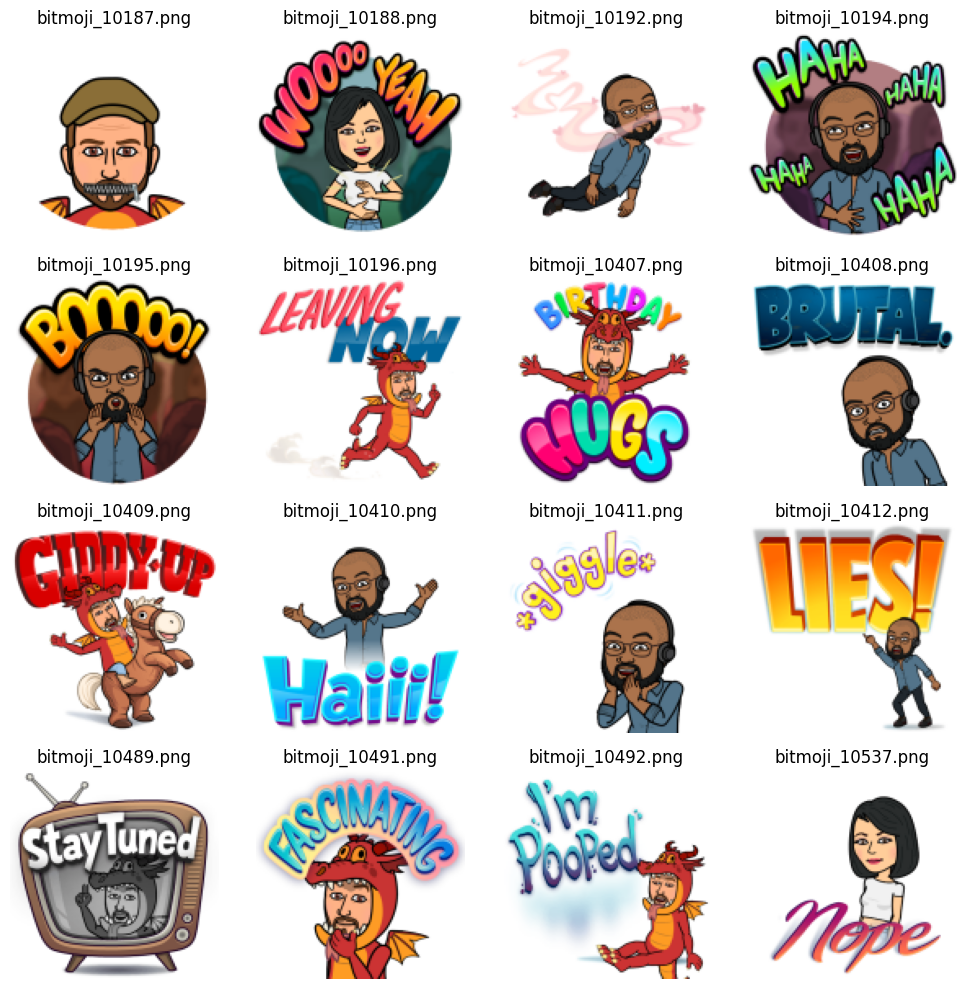

In [ ]:
 # Function to read and display images
def display_images(image_folder, num_images=5):  # Default number of images is 5
    # Check if the path exists
    if not os.path.exists(image_folder):
        print("The path does not exist.")
        return

    # List all image files in the folder
    images = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))])

    if not images:
        print("No images found in this path.")
        return

    # Select a certain number of images from the beginning
    selected_images = images[:num_images]  # Select the first num_images images

    # Display images
    plt.figure(figsize=(10, 10))
    for i, image_name in enumerate(selected_images):
        image_path = os.path.join(image_folder, image_name)
        image = Image.open(image_path)

        # For displaying in Grid
        plt.subplot(4, 4, i + 1)  # Display in a grid layout
        plt.imshow(image)
        plt.axis('off')  # Hide the axes
        plt.title(image_name)

    plt.tight_layout()
    plt.show()

# Input the folder path and the number of images to display
image_folder_path = input("/content/neural-networks/notebooks/data/bitmoji_rgb/train/not_tom")
num_images_to_display = int(input("16"))
display_images(image_folder_path, num_images_to_display)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


##Conditional Deep Convolutional GAN

In [ ]:
# Training Parameters
IMAGE_SIZE = 64
BATCH_SIZE = 64
LATENT_SIZE =100
NUM_EPOCHS = 1000
NUM_CLASSES = 2  # Tom and Not-Tom
LR = 0.0001

IMAGE_DIR = '/content/neural-networks/notebooks/data/bitmoji_rgb/train'

# Transforms
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Normalize to [-1, 1]
])
# Dataset and DataLoader
bitmoji_dataset = datasets.ImageFolder(root=IMAGE_DIR, transform=data_transforms)
bitmoji_loader = torch.utils.data.DataLoader(bitmoji_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Classes: {bitmoji_dataset.classes}")


In [ ]:
def conv_block(in_channels, out_channels, kernel_size, stride, padding, batch_norm=True):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

def convtrans_block(in_channels, out_channels, kernel_size, stride, padding, batch_norm=True):
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_channels):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.main = nn.Sequential(
            convtrans_block(latent_dim * 2, 512, kernel_size=4, stride=1, padding=0),
            convtrans_block(512, 256, kernel_size=4, stride=2, padding=1),
            convtrans_block(256, 128, kernel_size=4, stride=2, padding=1),
            convtrans_block(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embedding(labels)
        label_embedding = label_embedding.unsqueeze(2).unsqueeze(3)
        gen_input = torch.cat((noise, label_embedding), dim=1)
        return self.main(gen_input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_channels):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, img_channels * IMAGE_SIZE * IMAGE_SIZE)
        self.main = nn.Sequential(
            conv_block(img_channels * 2, 64, kernel_size=4, stride=2, padding=1, batch_norm=False),
            conv_block(64, 128, kernel_size=4, stride=2, padding=1),
            conv_block(128, 256, kernel_size=4, stride=2, padding=1),
            conv_block(256, 512, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        label_embedding = self.label_embedding(labels).view(labels.size(0), 3, IMAGE_SIZE, IMAGE_SIZE)
        d_input = torch.cat((img, label_embedding), dim=1)
        return self.main(d_input)

In [ ]:
# Initialize Models
generator = Generator(LATENT_SIZE, NUM_CLASSES, img_channels=3).to(device)
discriminator = Discriminator(NUM_CLASSES, img_channels=3).to(device)

criterion = nn.BCELoss()
optimizerG = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
fixed_noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)  # Fixed noise vector

# Lists to keep track of progress
img_list = []
gen_losses = []
dis_losses = []
ITERS = 0

print("Begin training...")
for epoch in range(NUM_EPOCHS):
    for real_batch, labels in bitmoji_loader:
        labels = labels.to(device)

        ### STEP 1: Train Discriminator
        discriminator.zero_grad()
        real_batch = real_batch.to(device)
        real_labels = torch.ones((real_batch.size(0),), dtype=torch.float, device=device)
        output = discriminator(real_batch, labels).view(-1)
        loss_real = criterion(output, real_labels)
        loss_real.backward()
        D_real = output.mean().item()

        noise = torch.randn(real_batch.size(0), LATENT_SIZE, 1, 1, device=device)
        fake_batch = generator(noise, labels)
        fake_labels = torch.zeros_like(real_labels)
        output = discriminator(fake_batch.detach(), labels).view(-1)
        loss_fake = criterion(output, fake_labels)
        loss_fake.backward()
        D_fake = output.mean().item()

        optimizerD.step()
        loss_dis = loss_real + loss_fake

        ### STEP 2: Train Generator
        generator.zero_grad()
        output = discriminator(fake_batch, labels).view(-1)
        loss_gen = criterion(output, real_labels)
        loss_gen.backward()
        optimizerG.step()

        # Save losses
        gen_losses.append(loss_gen.item())
        dis_losses.append(loss_dis.item())

        if ITERS % 50 == 0:
            print(f"Epoch ({epoch + 1}/{NUM_EPOCHS})",
                  f"Iteration ({ITERS + 1})",
                  f"Loss_G: {loss_gen.item():.4f}",
                  f"Loss_D: {loss_dis.item():.4f}",
                  f"D_real: {D_real:.4f}",
                  f"D_fake: {D_fake:.4f}")

        ITERS += 1

    # Store loss and track image evolution
    if epoch % 2 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise, torch.randint(0, NUM_CLASSES, (BATCH_SIZE,), device=device)).detach().cpu()
        img_list.append(utils.make_grid(fake_images, nrow=5, normalize=True))

print("Finished training!")


Classes: ['not_tom', 'tom']
Begin training...
Epoch (1/1000) Iteration (1) Loss_G: 3.3425 Loss_D: 1.4962 D_real: 0.5260 D_fake: 0.5688
Epoch (2/1000) Iteration (51) Loss_G: 6.9666 Loss_D: 0.2244 D_real: 0.9608 D_fake: 0.1640
Epoch (4/1000) Iteration (101) Loss_G: 6.5906 Loss_D: 0.8532 D_real: 0.9072 D_fake: 0.5194
Epoch (6/1000) Iteration (151) Loss_G: 3.3226 Loss_D: 1.1286 D_real: 0.6047 D_fake: 0.2697
Epoch (8/1000) Iteration (201) Loss_G: 4.0271 Loss_D: 0.4139 D_real: 0.7991 D_fake: 0.1516
Epoch (10/1000) Iteration (251) Loss_G: 4.0383 Loss_D: 0.7703 D_real: 0.7725 D_fake: 0.3425
Epoch (12/1000) Iteration (301) Loss_G: 6.4340 Loss_D: 0.7742 D_real: 0.9245 D_fake: 0.4642
Epoch (13/1000) Iteration (351) Loss_G: 4.9768 Loss_D: 0.2704 D_real: 0.8561 D_fake: 0.0742
Epoch (15/1000) Iteration (401) Loss_G: 4.4964 Loss_D: 0.4855 D_real: 0.8049 D_fake: 0.1676
Epoch (17/1000) Iteration (451) Loss_G: 4.2217 Loss_D: 0.4424 D_real: 0.7920 D_fake: 0.1249
Epoch (19/1000) Iteration (501) Loss_G: 6.

Visualizing generated images...


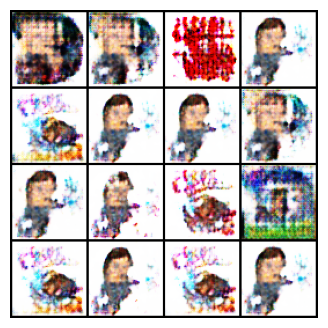

In [ ]:
from torchvision.utils import save_image, make_grid
# Visualize generated images
print("Visualizing generated images...")
fixed_noise = torch.randn(16, LATENT_SIZE, 1, 1, device=device)
fake_images = generator(fixed_noise, torch.randint(0, NUM_CLASSES, (16,), device=device)).detach().cpu()

grid = make_grid(fake_images, nrow=4, normalize=True)
plt.figure(figsize=(4, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()